CSCI E-82 - Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Project - GAM Notebook

### *Dominic Murphy and David Modjeska*

------

# Introduction

In [1]:
import math
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle

from pygam import GAM            ##pip install pygam; pip install --user scikit-sparse
from pygam import LinearGAM  
from pygam.utils import generate_X_grid

%matplotlib inline
from IPython.display import Image, display, HTML, clear_output

In [2]:
def my_display(str): 
    display(HTML(str))
    
def my_display_df(df): 
    display(HTML(df.to_html(index=False)))
    
def my_linespace():
    my_display('<p>')
    
plt.rcParams["patch.force_edgecolor"] = True   
plt.style.use('ggplot')

palette = sns.color_palette(palette = 'deep')
sns.set_palette(palette)

In [3]:
# suppress warnings for submission only

HTML('''<style>
div.output_stderr {display: none}
''')

# Modeling

*Note: some code has been adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/*

#### Helper function to convert a dataframe for supervised learning

In [4]:
def series_to_supervised(data, n_in = 1, n_out = 1, drop_nan = True):
    columns = data.columns.values
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(columns[j] + '(t-%d)' % (i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(columns[j] + '(t)' % ()) for j in range(n_vars)]
        else:
            names += [(columns[j] + '(t+%d)' % (i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    # drop rows with NaN values
    if drop_nan:
        agg.dropna(inplace = True)
    
    return agg

#### Load data

In [5]:
data = pd.read_csv('source_data.csv', parse_dates = ['date_key'])
print(data.shape)

(6551, 151)


#### Display first few rows of data

In [6]:
data.head()

,date_dayofyear,date_key,date_month,date_qtr,AU_IS_WORK_DAY,US_IS_WORK_DAY,CA_IS_WORK_DAY,UK_IS_WORK_DAY,IS_EURO,AU_FX,...,UK_FX_MA_090,UK_FX_MA_180,UK_FX_MA_365,temperature,AU_BMP_Ratio,CA_BMP_Ratio,UK_BMP_Ratio,CH_BMP_Ratio,JP_BMP_Ratio,time_index
0,3,2000-01-03,1,1,0,1,1,0,1,0.6591,...,1.628023,1.617005,1.617082,-0.943863,0.680107,0.784969,1.231594,3.715825,1.151735,0
1,4,2000-01-04,1,1,1,1,1,0,1,0.6562,...,1.627812,1.617446,1.617025,-0.940453,0.677115,0.782104,1.239163,3.658705,1.136206,1
2,5,2000-01-05,1,1,1,1,1,1,1,0.6550,...,1.627695,1.617946,1.616983,-0.940453,0.675876,0.782104,1.242570,3.649538,1.128760,2
3,6,2000-01-06,1,1,1,1,1,1,1,0.6540,...,1.627645,1.618471,1.616963,-0.936941,0.674845,0.779259,1.247112,3.652829,1.113523,3
4,7,2000-01-07,1,1,1,1,1,1,1,0.6548,...,1.627491,1.618938,1.616933,-0.936941,0.675670,0.782805,1.240223,3.672339,1.113735,4


#### Extract feature columns

In [7]:
feature_data = data.drop(['date_key', 'time_index'], axis = 1)
feature_cols = feature_data.columns
n_feature_cols = feature_data.shape[1]

## Helper functions

#### Calculate the latest start date among a set of features

In [8]:
euro_start_date = '2000-01-03'

def get_start_row_index(data, col_names):
    return(max([data[col].isnull().idxmin() for col in col_names]))

#### Reduce dimensionality of X by PCA

In [9]:
def pca_X(currency_name, X):
    
    # fit a PCA for exploration only
    n_pcs_total = int(np.round(X.shape[1] - 1))
    pca = PCA(n_components = n_pcs_total, svd_solver = 'full', random_state = 0)
    pca.fit(X)
    ratios = np.cumsum(pca.explained_variance_ratio_)
    
    # scree plot of variances explained
    plt.plot(1.0 - ratios)
    plt.title(currency_name + " - PCA cumulative variance explained")
    plt.xlabel("Number of components")
    plt.ylabel("% of variance not explained")
    plt.show()
    
    # computer number of components to use
    n_pcs_to_use = np.where(ratios >= 0.999)[0][0] + 1
    print('Cumulative variance explained by the first ' + str(n_pcs_to_use) + ' components: ' + 
          str(np.round(ratios[n_pcs_to_use], 4)))
    
    # fit a PCA and transform the data
    pca = PCA(n_components = n_pcs_to_use, svd_solver = 'arpack', random_state = 0)
    pca.fit(X)    
    X_pca = pd.DataFrame(pca.transform(X))
    
    return(X_pca, pca)

#### Helper function to manage data reduction by PCA

In [10]:
def do_pca_X(currency_name, do_pca, n_past_lags, this_data_reframed):
    if do_pca and (n_past_lags > 1):
        X = this_data_reframed.iloc[:, :-1]        
        X_pca, pca = pca_X(currency_name, X)
        this_data_pca = X_pca        
        this_data_pca['y'] = this_data_reframed.iloc[:, -1].values 

        my_display("<h4>Shape of train and test data after PCA</h4>")
        print('Reduced data shape: ' + str(this_data_pca.shape))
    else:
        this_data_pca = this_data_reframed
        pca = None
        
    return(this_data_pca, pca)

#### Helper function to reframe data for supervised training

In [11]:
def reframe_data(this_data_scaled, n_past_lags, n_future_lags, n_these_cols):
    this_data_reframed = series_to_supervised(this_data_scaled, n_past_lags, n_future_lags) # X, y, and extra
    this_data_reframed_past = this_data_reframed.iloc[:, :(n_past_lags*n_these_cols)] # X = past = predictor
    this_data_reframed_future = this_data_reframed.iloc[:, -n_these_cols] # y = future = response
    this_data_reframed = pd.concat([this_data_reframed_past, this_data_reframed_future], axis = 1) # X and y
    
    print('Reframed data shape: ' + str(this_data_reframed.shape))
    return(this_data_reframed)

#### Prepare data for one model

In [12]:
n_past_lags = 7
n_future_lags = 7

def prep_model_data(currency_name, col_names, do_pca = False, verbose = 2):
    my_display("<h3>Prepare model data</h3>")
    
    # extract untransformed data
    n_these_cols = len(col_names)
    start_row_index = get_start_row_index(data, col_names)
    this_data = data[col_names].iloc[start_row_index:, :]
    n_these_rows = this_data.shape[0]
    
    # print data's time period
    print("Time period: " + str(data.date_key.dt.date[0]) + ' - ' + 
          str(data.date_key.dt.date[n_these_rows - 1]))
    
    # list untransformed model features
    if not do_pca:
        my_display("<h4>Features in Model</h4>")
        print(*col_names, sep = ', ')
        print()
    
    # scale data
    scaler = MinMaxScaler(feature_range = (0, 1))
    this_data_scaled = pd.DataFrame(scaler.fit_transform(this_data))
    this_data_scaled.columns = col_names
    print('Scaled data shape: ' + str(this_data_scaled.shape))
    
    # reframe data for supervised training
    this_data_reframed = reframe_data(this_data_scaled, n_past_lags, n_future_lags, n_these_cols)

    # PCA X (if needed)
    this_data_pca, pca = do_pca_X(currency_name, do_pca, n_past_lags, this_data_reframed)
    
    # display first few rows of supervised data
    if (verbose == 2 and not do_pca):
        my_display("<h4>First few rows of supervised data</h4>")
        my_linespace()
        my_display_df(this_data_pca.head())
        my_linespace()

    # predict y naively as the previous day (and drop initial rows with resulting NaNs)
    yhat_naive = this_data_pca.iloc[:, -1].shift(n_future_lags)
    this_data_pca = this_data_pca.iloc[n_future_lags:, :]
    yhat_naive = yhat_naive.iloc[n_future_lags:, ]
        
    # split into train and test sets
    train, test, yhat_naive_train, yhat_naive_test = \
        train_test_split(this_data_pca, yhat_naive, test_size = 0.33, shuffle = True, random_state = 0)
    
    # split into input and outputs
    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
    
    if verbose == 2:
        my_display("<h4>Shape of train and test data</h4>")
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    return(train_X, test_X, train_y, test_y, scaler, pca, yhat_naive_test, n_these_cols)

#### Helper function to instantiate and fit one model, and plot the feature importances

In [13]:
#Gam Specific call in function
def define_fit_model(currency_name, train_X, train_y, do_pca = False, verbose = 2):
    my_display("<h3>Fit model</h3>")
    
    # fit model
    model = LinearGAM().gridsearch(train_X, train_y)  

    # plot feature importances
    if verbose == 2 and not do_pca  :
        plot_splines(model, train_X, feature_col_names = train_X.columns[-5:], currency_name = currency_name)
                
    return(model)

In [14]:
#Gam Specific Funciton
#plots splines
def plot_splines(model, train_X, feature_col_names, currency_name):
    my_display("<h3>Feature Splines</h3>")
               
    XX = generate_X_grid(model)
    plt.rcParams['figure.figsize'] = (28, 8)
    fig, axs = plt.subplots(1, len(feature_col_names))
    titles = feature_col_names
    
    #last six
    for ax_i, i in enumerate(range(train_X.shape[1]-len(feature_col_names), train_X.shape[1],1)):
        if len(feature_col_names) == 1:
            ax = axs 
        else:    
            ax = axs[ax_i]   
        pdep, confi = model.partial_dependence(XX, feature=i+1, width=.95)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
        ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
        ax.set_title(currency_name + '- ' + titles[ax_i],fontsize=26)
    plt.show()

#### Helper function to inverse transform the data

In [15]:
def inverse_transform(y, X, scaler, pca, n_cols):
    if pca is not None:
        X = pca.inverse_transform(X)
    else:
        X = X.values
        
    inv_y = np.concatenate((y, X[:, 1:n_cols]), axis = 1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    
    return(inv_y)

#### Helper function to plot histogram of prediction errors

In [16]:
def vis_error(currency_name, error):
    fig, ax = plt.subplots(figsize = (8.5, 4))
    sns.distplot(a = error, kde = False, bins = 40, hist_kws = {'alpha': 0.8}, ax = ax)
    ax.set_xlabel('Error')
    ax.set_ylabel('Frequency')
    ax.set_title(currency_name + ' - Distribution of test RMSE')
    plt.show()

#### Helper function to plot predicted vs. actual percentage change

In [17]:
def vis_percentage_pred(currency_name, y_pred_perc ,y_actual_perc, verbose=2):
    df = pd.DataFrame({'Predicted': y_pred_perc,'Actual'  : y_actual_perc})
    
    is_green = lambda a, b: (((a <= 0) and (b <=0)) or ((a > 0) and (b > 0))) * 1
    df['isGreen'] = df.Actual.combine(df.Predicted, func=is_green)
    
    fig, ax = plt.subplots(figsize = (21, 6))
    ax.scatter(df[df.isGreen==1].Predicted ,df[df.isGreen==1].Actual , edgecolors=(0, 0, 0), 
               alpha=.4, c='g', label='Profit') #cmap
    ax.scatter(df[df.isGreen==0].Predicted ,df[df.isGreen==0].Actual , edgecolors=(0, 0, 0), 
               alpha=.4, c='r', label='Loss')
    plt.axhline(y=0.0, color='grey', linestyle='-')
    plt.axvline(x=0.0, color='grey', linestyle='-')
    ax.set_xlabel('Predicted (% Change)')
    ax.set_ylabel('Actual  (% Change)') 
    ax.set_title(currency_name + ' - Predicted vs. Actual (% Change)')
    plt.legend()
    
    plt.show()

#### Score a model using RMSE with test data

In [18]:
no_score = None

def score_model(currency_name, best_model, test_X, test_y, scaler, pca, inv_yhat_naive, n_cols, verbose = 2):
    my_display("<h3>Score model on test data</h3>")
    
    # make a prediction on test data
    yhat = best_model.predict(test_X.values).reshape(-1, 1)

    # invert/reverse/undo scaling for forecast
    inv_yhat = inverse_transform(yhat, test_X, scaler, pca, n_cols)    
    
    # invert scaling for actual
    test_y = test_y.values.reshape((len(test_y), 1))
    inv_y = inverse_transform(test_y, test_X, scaler, pca, n_cols)
    
    # invert scaling for y-hat naive
    inv_yhat_naive = inv_yhat_naive.values.reshape((len(inv_yhat_naive), 1))  
    inv_yhat_naive = inverse_transform(inv_yhat_naive, test_X, scaler, pca, n_cols)    
    
    # naive model
    my_display("<h4>RMSE from naive model that always predicts the previous week's rate</h4>")
    naive_rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat_naive))
    print("RMSE: " + str(np.round(naive_rmse, 5)))
    
    # calculate RMSE on test data
    my_display("<h4>RMSE from fitted model</h4>")
    test_rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    print("RMSE: " + str(np.round(test_rmse, 5)))

    # calculate relative prediction error percentages
    y_pred_perc   = 100 * (1 - (inv_yhat/inv_yhat_naive))
    y_actual_perc = 100 * (1 - (inv_y   /inv_yhat_naive))
    y_perc_error  = (np.abs(y_pred_perc - y_actual_perc)).mean()    
    
    # visualize relative prediction error percentages
    if verbose == 2 and pca is not None:
        vis_error(currency_name, inv_yhat)
        vis_percentage_pred(currency_name, y_pred_perc,y_actual_perc)    
    
    return(naive_rmse, test_rmse)

#### Top-level function to create, fit, and score one model

In [19]:
def do_one_model(currency_name, feature_col_names, do_pca = False, verbose = 2):
    
    train_X, test_X, train_y, test_y, scaler, pca, yhat_naive_test, n_features = \
        prep_model_data(currency_name, feature_col_names, do_pca, verbose)
    
    best_model = define_fit_model(currency_name, train_X, train_y, do_pca, verbose)

    naive_rmse, test_rmse = score_model(currency_name, best_model, test_X, test_y, scaler, pca, 
                                        yhat_naive_test, n_features, verbose = verbose)
    
    return(naive_rmse, test_rmse)

#### Create a dataframe to accumulate modeling results for all currencies

In [20]:
all_results = pd.DataFrame()

#### Accumulate results from one model

In [21]:
def accum_results(all_results, currency, naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse):
    results = pd.DataFrame({'Currency': currency, 
                              'Naive': naive_rmse, 
                              'FX Only': fx_rmse, 
                              'FX + Features': fx_features_rmse,
                              'All Features': fx_all_rmse},
                            index = range(1))
    all_results = all_results.append(results).reset_index(drop = True)
    return(all_results)

## Australia

### FX rates only

In [22]:
naive_rmse, fx_rmse = do_one_model('AUD', feature_col_names = ['AU_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


AU_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:00 ETA:  0:00:04/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:00 ETA:  0:00:02/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

RMSE: 0.01386


RMSE: 0.01373


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


AU_FX, GOLD, AU_FX_MA_007, CA_FX, AU_COAL

Scaled data shape: (6551, 5)
Reframed data shape: (6538, 36)


AU_FX(t-7),GOLD(t-7),AU_FX_MA_007(t-7),CA_FX(t-7),AU_COAL(t-7),AU_FX(t-6),GOLD(t-6),AU_FX_MA_007(t-6),CA_FX(t-6),AU_COAL(t-6),AU_FX(t-5),GOLD(t-5),AU_FX_MA_007(t-5),CA_FX(t-5),AU_COAL(t-5),AU_FX(t-4),GOLD(t-4),AU_FX_MA_007(t-4),CA_FX(t-4),AU_COAL(t-4),AU_FX(t-3),GOLD(t-3),AU_FX_MA_007(t-3),CA_FX(t-3),AU_COAL(t-3),AU_FX(t-2),GOLD(t-2),AU_FX_MA_007(t-2),CA_FX(t-2),AU_COAL(t-2),AU_FX(t-1),GOLD(t-1),AU_FX_MA_007(t-1),CA_FX(t-1),AU_COAL(t-1),AU_FX(t+6)
0.284447,0.017248,0.274038,0.151440,0.006426,0.279768,0.015459,0.276656,0.146078,0.006426,0.277832,0.015490,0.277754,0.146078,0.006426,0.276218,0.014422,0.277778,0.140755,0.006426,0.277509,0.015429,0.277497,0.147389,0.006426,0.278208,0.015368,0.277077,0.145272,0.006426,0.278907,0.015307,0.276516,0.143161,0.006426,0.295041
0.279768,0.015459,0.276656,0.146078,0.006426,0.277832,0.015490,0.277754,0.146078,0.006426,0.276218,0.014422,0.277778,0.140755,0.006426,0.277509,0.015429,0.277497,0.147389,0.006426,0.278208,0.015368,0.277077,0.145272,0.006426,0.278907,0.015307,0.276516,0.143161,0.006426,0.279606,0.015246,0.275815,0.141056,0.006426,0.294369
0.277832,0.015490,0.277754,0.146078,0.006426,0.276218,0.014422,0.277778,0.140755,0.006426,0.277509,0.015429,0.277497,0.147389,0.006426,0.278208,0.015368,0.277077,0.145272,0.006426,0.278907,0.015307,0.276516,0.143161,0.006426,0.279606,0.015246,0.275815,0.141056,0.006426,0.281865,0.015246,0.276118,0.140855,0.006426,0.292352
0.276218,0.014422,0.277778,0.140755,0.006426,0.277509,0.015429,0.277497,0.147389,0.006426,0.278208,0.015368,0.277077,0.145272,0.006426,0.278907,0.015307,0.276516,0.143161,0.006426,0.279606,0.015246,0.275815,0.141056,0.006426,0.281865,0.015246,0.276118,0.140855,0.006426,0.282349,0.015581,0.276773,0.142860,0.006426,0.291384
0.277509,0.015429,0.277497,0.147389,0.006426,0.278208,0.015368,0.277077,0.145272,0.006426,0.278907,0.015307,0.276516,0.143161,0.006426,0.279606,0.015246,0.275815,0.141056,0.006426,0.281865,0.015246,0.276118,0.140855,0.006426,0.282349,0.015581,0.276773,0.142860,0.006426,0.299935,0.015551,0.280208,0.148400,0.006426,0.296547


(4375, 35) (4375,) (2156, 35) (2156,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:02 ETA:  0:00:20/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:04 ETA:  0:00:18/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

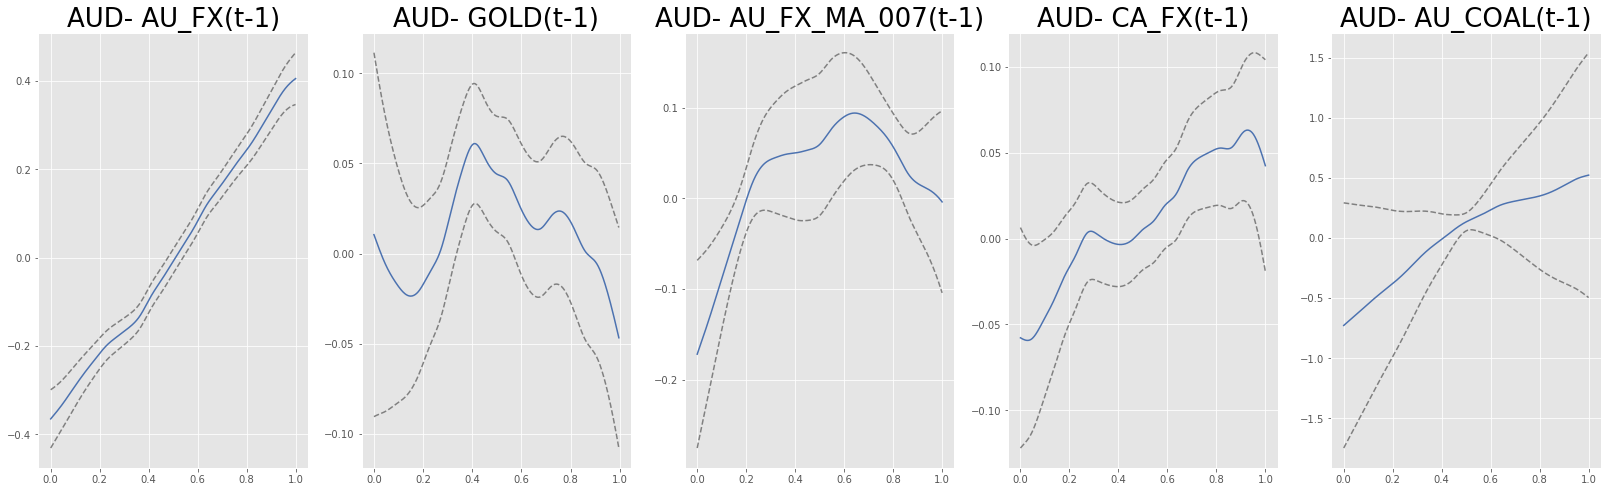

RMSE: 0.01386


RMSE: 0.0122


In [23]:
naive_rmse, fx_features_rmse = do_one_model('AUD', feature_col_names = ['AU_FX', 'GOLD','AU_FX_MA_007','CA_FX', 'AU_COAL'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 141)
Reframed data shape: (4708, 988)


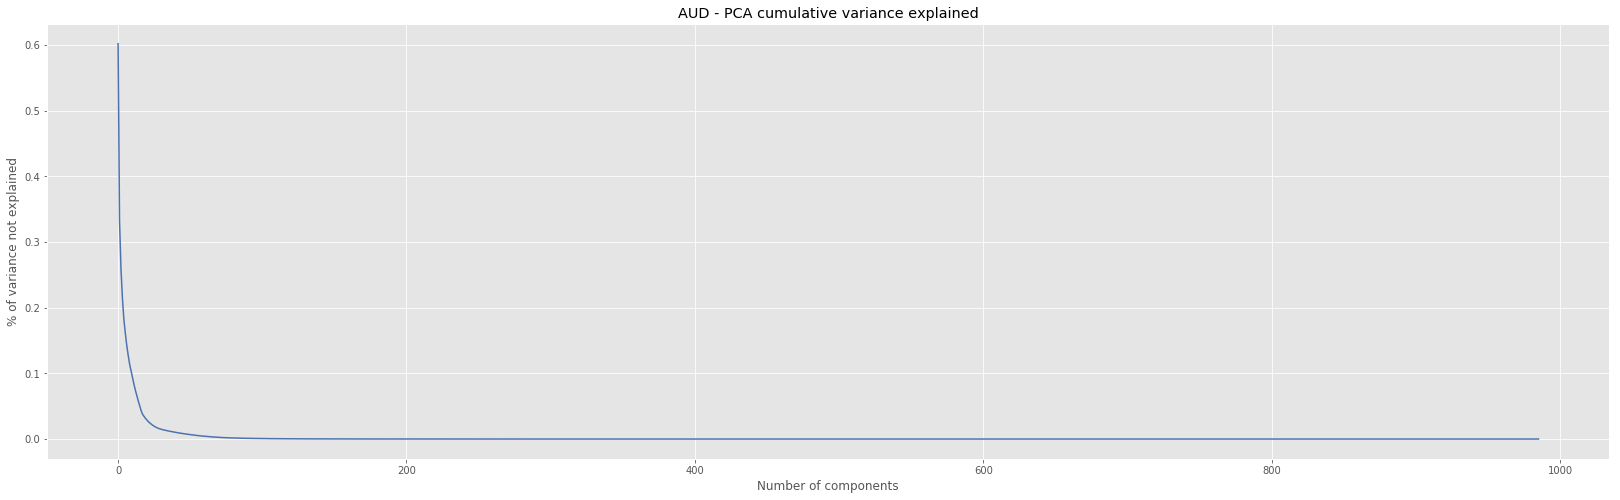

Cumulative variance explained by the first 94 components: 0.9991


Reduced data shape: (4708, 95)


(3149, 94) (3149,) (1552, 94) (1552,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/pygam.py:597: RuntimeWarning: divide by zero encountered in log
  return np.log(self.distribution.pdf(y=y, mu=mu, weights=weights)).sum()
  9% (1 of 11) |##                        | Elapsed Time: 0:00:17 ETA:  0:02:57/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Spar

RMSE: 0.01553


RMSE: 0.0092


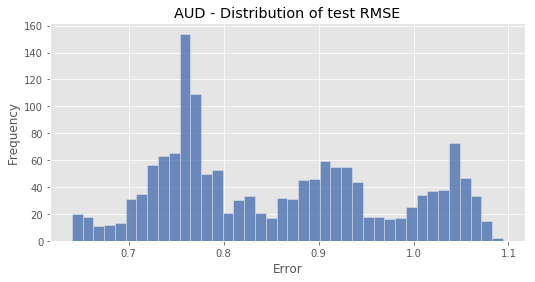

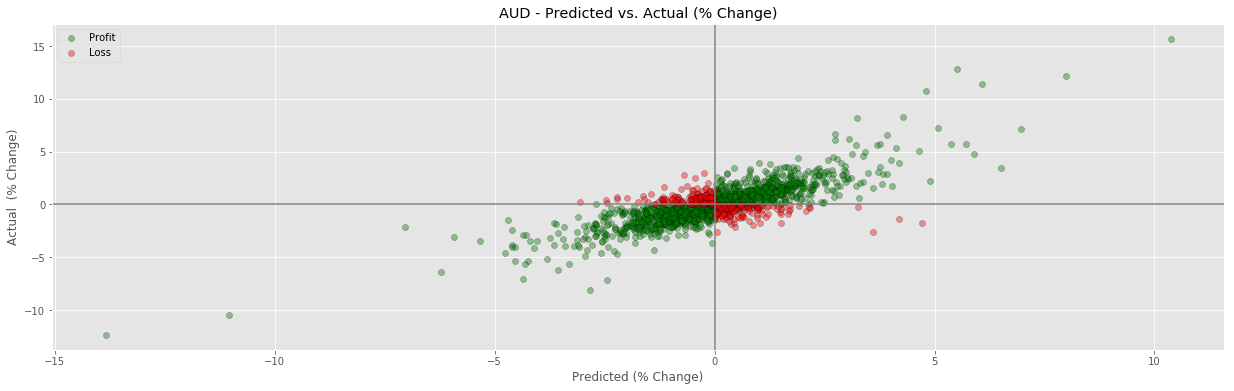

In [24]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('AU_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('AUD', feature_col_names = ['AU_FX'] + cols, do_pca = True)

In [25]:
all_results = accum_results(all_results, 'AUD', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

## Canada

### FX rates only

In [26]:
naive_rmse, fx_rmse = do_one_model('CAD', feature_col_names = ['CA_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


CA_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:00 ETA:  0:00:02/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:00 ETA:  0:00:02/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

RMSE: 0.01081


RMSE: 0.0106


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


CA_FX, CA_GDP, CA_CPI, US_GDP

Scaled data shape: (6551, 4)
Reframed data shape: (6538, 29)


CA_FX(t-7),CA_GDP(t-7),CA_CPI(t-7),US_GDP(t-7),CA_FX(t-6),CA_GDP(t-6),CA_CPI(t-6),US_GDP(t-6),CA_FX(t-5),CA_GDP(t-5),CA_CPI(t-5),US_GDP(t-5),CA_FX(t-4),CA_GDP(t-4),CA_CPI(t-4),US_GDP(t-4),CA_FX(t-3),CA_GDP(t-3),CA_CPI(t-3),US_GDP(t-3),CA_FX(t-2),CA_GDP(t-2),CA_CPI(t-2),US_GDP(t-2),CA_FX(t-1),CA_GDP(t-1),CA_CPI(t-1),US_GDP(t-1),CA_FX(t+6)
0.151440,1.000000,0.559332,0.608791,0.146078,0.998836,0.562212,0.613187,0.146078,0.997672,0.565092,0.617582,0.140755,0.996508,0.567972,0.621978,0.147389,0.995344,0.570853,0.626374,0.145272,0.994180,0.573733,0.630769,0.143161,0.993017,0.576613,0.635165,0.148029
0.146078,0.998836,0.562212,0.613187,0.146078,0.997672,0.565092,0.617582,0.140755,0.996508,0.567972,0.621978,0.147389,0.995344,0.570853,0.626374,0.145272,0.994180,0.573733,0.630769,0.143161,0.993017,0.576613,0.635165,0.141056,0.991853,0.579493,0.639560,0.147945
0.146078,0.997672,0.565092,0.617582,0.140755,0.996508,0.567972,0.621978,0.147389,0.995344,0.570853,0.626374,0.145272,0.994180,0.573733,0.630769,0.143161,0.993017,0.576613,0.635165,0.141056,0.991853,0.579493,0.639560,0.140855,0.990689,0.582373,0.643956,0.147692
0.140755,0.996508,0.567972,0.621978,0.147389,0.995344,0.570853,0.626374,0.145272,0.994180,0.573733,0.630769,0.143161,0.993017,0.576613,0.635165,0.141056,0.991853,0.579493,0.639560,0.140855,0.990689,0.582373,0.643956,0.142860,0.989525,0.585253,0.648352,0.145171
0.147389,0.995344,0.570853,0.626374,0.145272,0.994180,0.573733,0.630769,0.143161,0.993017,0.576613,0.635165,0.141056,0.991853,0.579493,0.639560,0.140855,0.990689,0.582373,0.643956,0.142860,0.989525,0.585253,0.648352,0.148400,0.988361,0.588134,0.652747,0.149513


(4375, 28) (4375,) (2156, 28) (2156,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:01 ETA:  0:00:16/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:03 ETA:  0:00:14/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

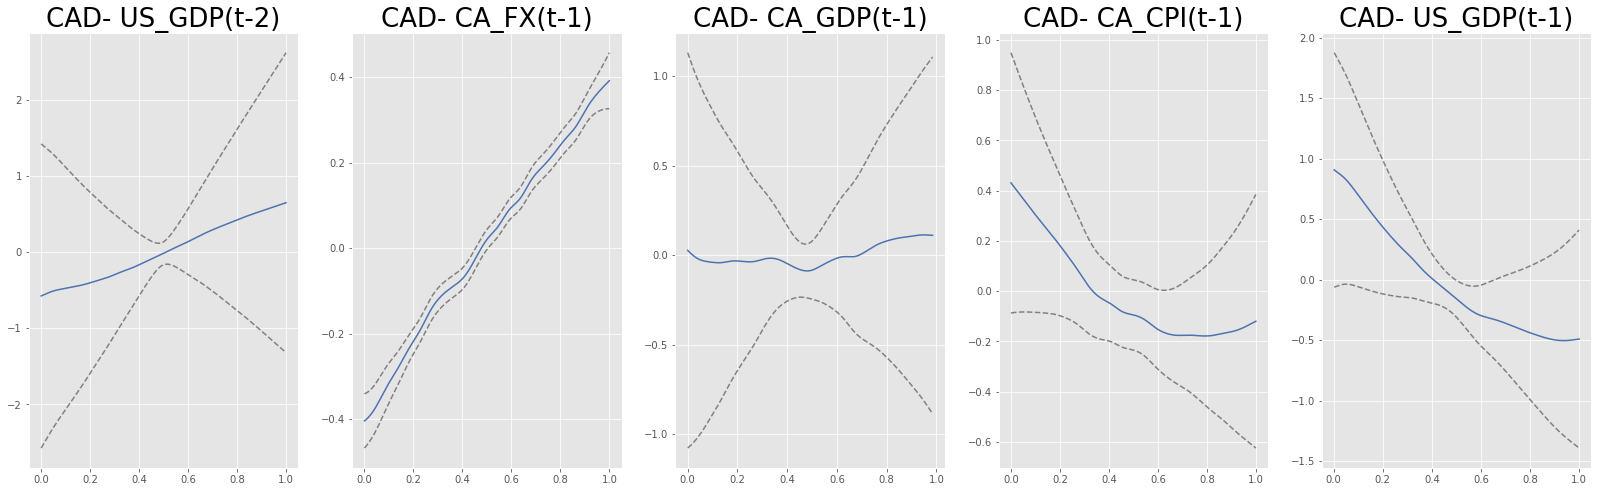

RMSE: 0.01081


RMSE: 0.00935


In [27]:
naive_rmse, fx_features_rmse = do_one_model('CAD', feature_col_names =  ['CA_FX', 'CA_GDP', 'CA_CPI', 'US_GDP'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 139)
Reframed data shape: (4708, 974)


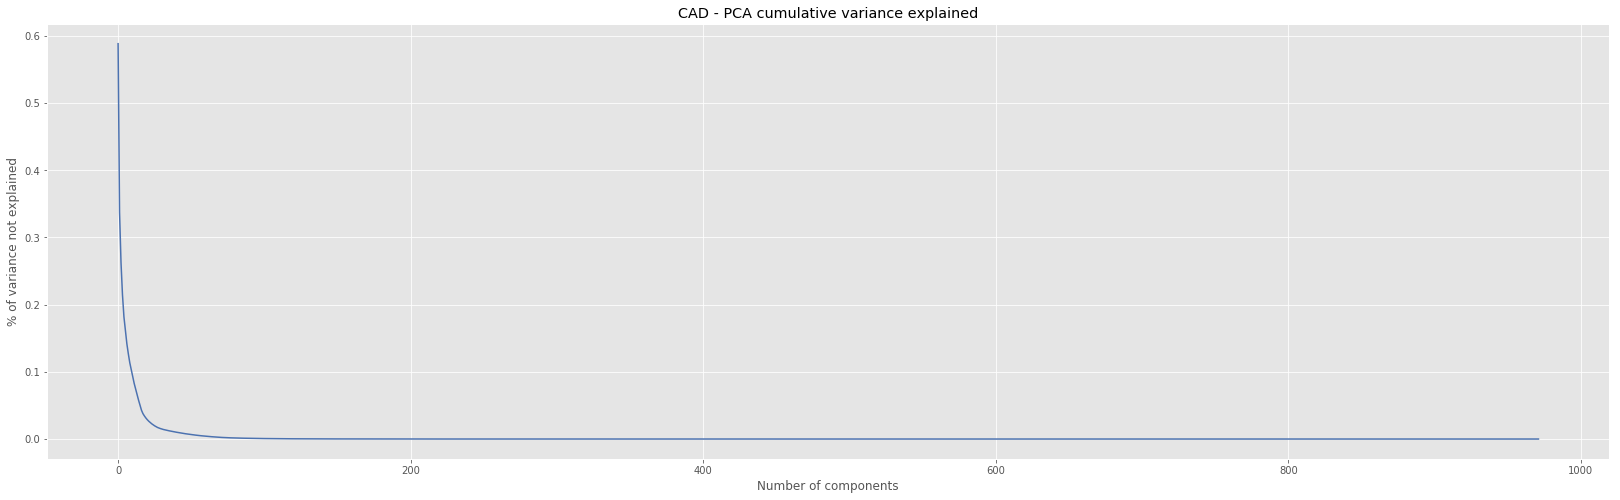

Cumulative variance explained by the first 93 components: 0.9991


Reduced data shape: (4708, 94)


(3149, 93) (3149,) (1552, 93) (1552,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/pygam.py:597: RuntimeWarning: divide by zero encountered in log
  return np.log(self.distribution.pdf(y=y, mu=mu, weights=weights)).sum()
  9% (1 of 11) |##                        | Elapsed Time: 0:00:17 ETA:  0:02:56/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Spar

RMSE: 0.01205


RMSE: 0.00721


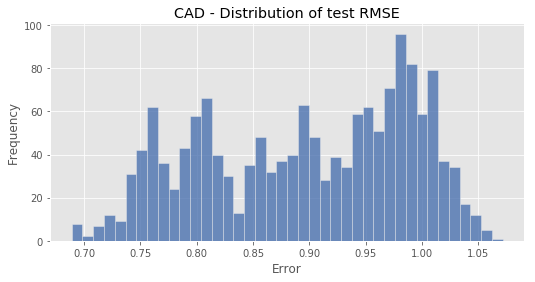

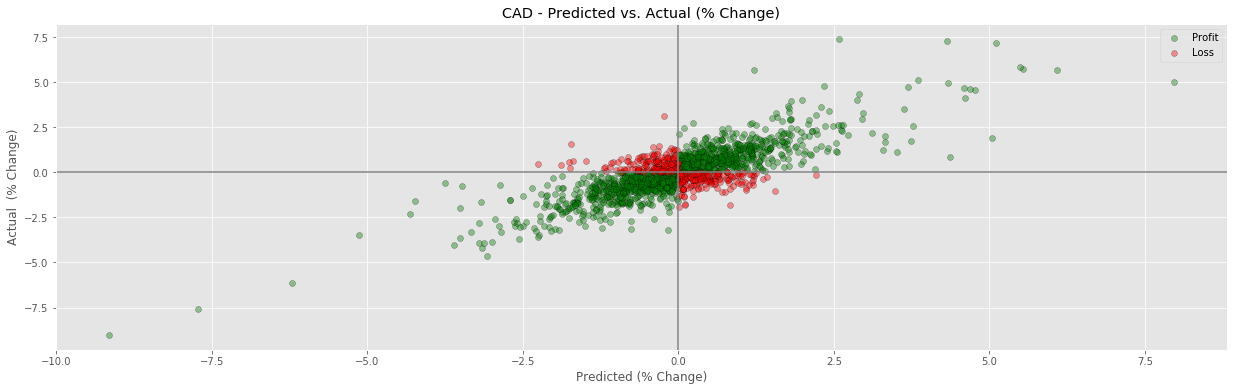

In [28]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('CA_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('CAD', feature_col_names = ['CA_FX'] + cols, do_pca = True)

In [29]:
all_results = accum_results(all_results, 'CAD', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

## EU

### FX rates only

In [30]:
naive_rmse, fx_rmse = do_one_model('EUR', feature_col_names = ['EU_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


EU_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:00 ETA:  0:00:02/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:00 ETA:  0:00:01/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

RMSE: 0.0169


RMSE: 0.0168


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


EU_FX, CH_FX, DE_INT_TB, US_INT_TB

Scaled data shape: (6551, 4)
Reframed data shape: (6538, 29)


EU_FX(t-7),CH_FX(t-7),DE_INT_TB(t-7),US_INT_TB(t-7),EU_FX(t-6),CH_FX(t-6),DE_INT_TB(t-6),US_INT_TB(t-6),EU_FX(t-5),CH_FX(t-5),DE_INT_TB(t-5),US_INT_TB(t-5),EU_FX(t-4),CH_FX(t-4),DE_INT_TB(t-4),US_INT_TB(t-4),EU_FX(t-3),CH_FX(t-3),DE_INT_TB(t-3),US_INT_TB(t-3),EU_FX(t-2),CH_FX(t-2),DE_INT_TB(t-2),US_INT_TB(t-2),EU_FX(t-1),CH_FX(t-1),DE_INT_TB(t-1),US_INT_TB(t-1),EU_FX(t+6)
0.243540,0.777068,0.641026,0.864422,0.263437,0.754884,0.641026,0.865626,0.266796,0.751324,0.641026,0.866831,0.265375,0.752602,0.641026,0.868035,0.261499,0.760179,0.641026,0.869240,0.259690,0.762644,0.641026,0.870444,0.257881,0.765109,0.641026,0.871649,0.239750
0.263437,0.754884,0.641026,0.865626,0.266796,0.751324,0.641026,0.866831,0.265375,0.752602,0.641026,0.868035,0.261499,0.760179,0.641026,0.869240,0.259690,0.762644,0.641026,0.870444,0.257881,0.765109,0.641026,0.871649,0.256072,0.767573,0.641026,0.872853,0.239599
0.266796,0.751324,0.641026,0.866831,0.265375,0.752602,0.641026,0.868035,0.261499,0.760179,0.641026,0.869240,0.259690,0.762644,0.641026,0.870444,0.257881,0.765109,0.641026,0.871649,0.256072,0.767573,0.641026,0.872853,0.265116,0.758536,0.641026,0.874057,0.239147
0.265375,0.752602,0.641026,0.868035,0.261499,0.760179,0.641026,0.869240,0.259690,0.762644,0.641026,0.870444,0.257881,0.765109,0.641026,0.871649,0.256072,0.767573,0.641026,0.872853,0.265116,0.758536,0.641026,0.874057,0.259819,0.763557,0.641026,0.875262,0.238372
0.261499,0.760179,0.641026,0.869240,0.259690,0.762644,0.641026,0.870444,0.257881,0.765109,0.641026,0.871649,0.256072,0.767573,0.641026,0.872853,0.265116,0.758536,0.641026,0.874057,0.259819,0.763557,0.641026,0.875262,0.258398,0.767847,0.641026,0.876466,0.240698


(4375, 28) (4375,) (2156, 28) (2156,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:01 ETA:  0:00:14/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:02 ETA:  0:00:13/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

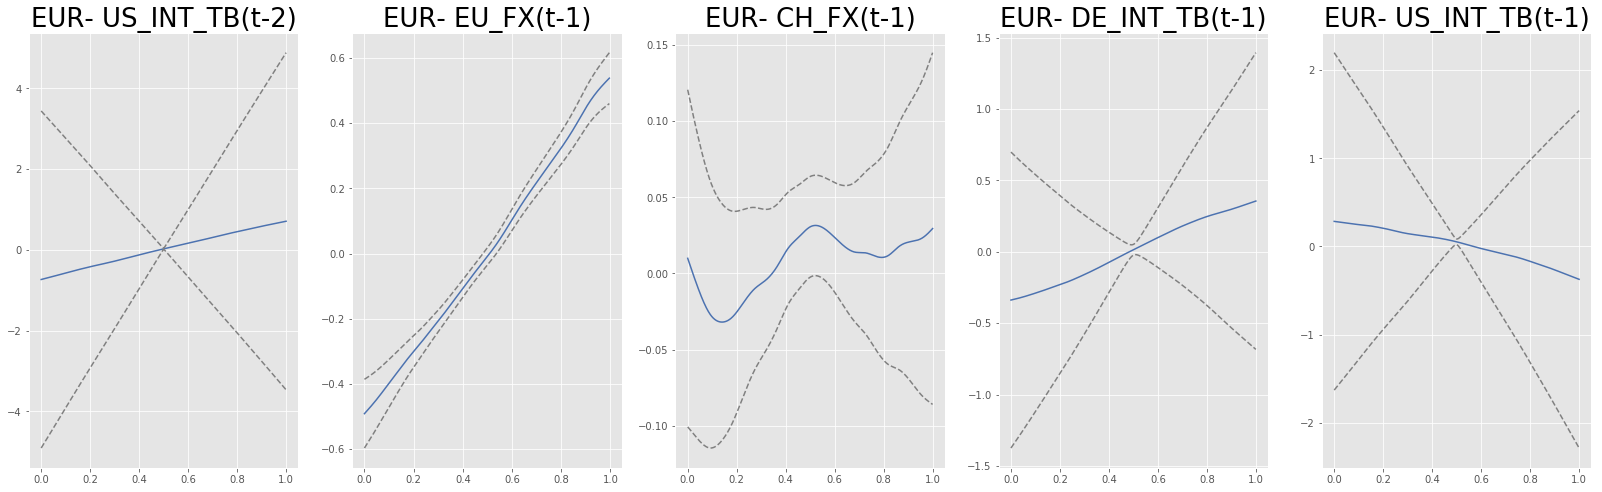

RMSE: 0.0169


RMSE: 0.01595


In [31]:
naive_rmse, fx_features_rmse = do_one_model('EUR', feature_col_names = \
    ['EU_FX', 'CH_FX', 'DE_INT_TB', 'US_INT_TB'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 141)
Reframed data shape: (4708, 988)


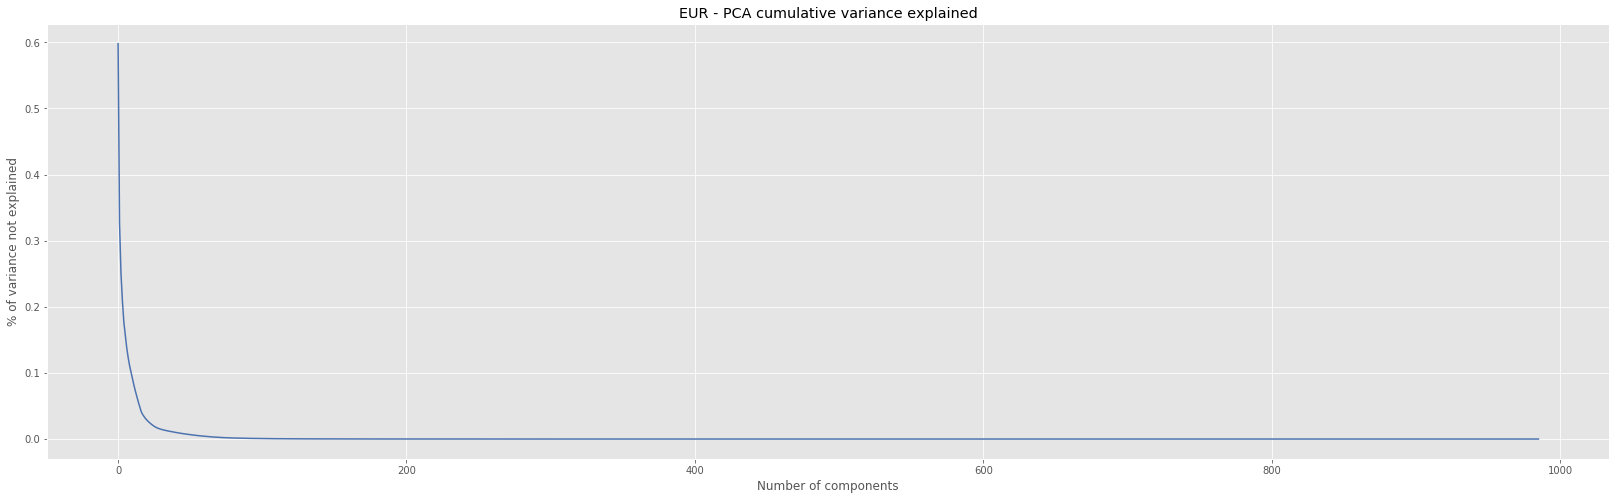

Cumulative variance explained by the first 93 components: 0.999


Reduced data shape: (4708, 94)


(3149, 93) (3149,) (1552, 93) (1552,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/pygam.py:597: RuntimeWarning: divide by zero encountered in log
  return np.log(self.distribution.pdf(y=y, mu=mu, weights=weights)).sum()
  9% (1 of 11) |##                        | Elapsed Time: 0:00:17 ETA:  0:02:51/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Spar

RMSE: 0.01811


RMSE: 0.0116


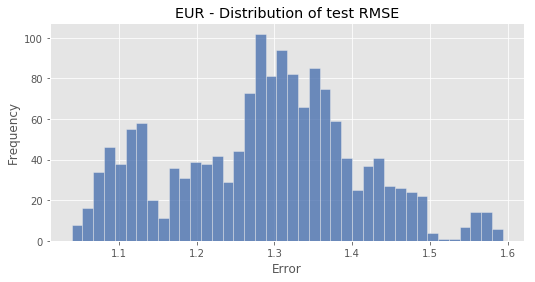

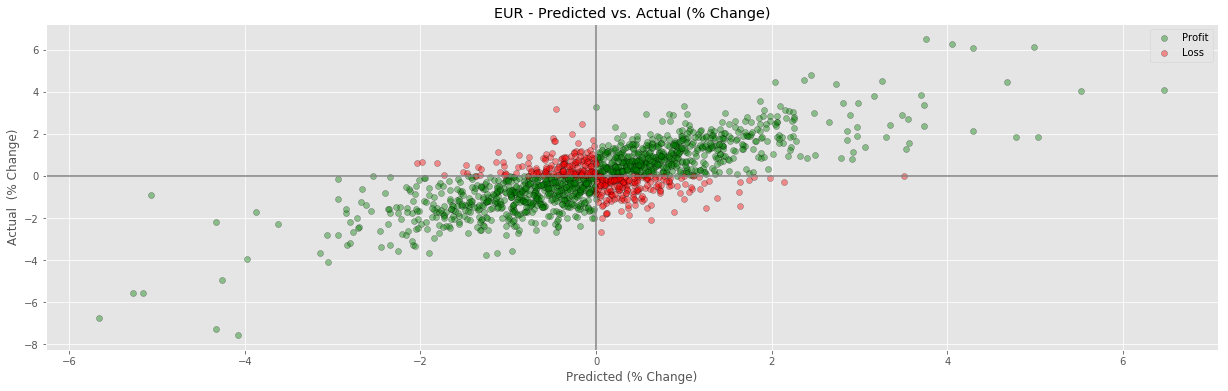

In [32]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('EU_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('EUR', feature_col_names = ['EU_FX'] + cols, do_pca = True)

In [33]:
all_results = accum_results(all_results, 'EUR', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

## Japan

### FX rates only

In [34]:
naive_rmse, fx_rmse = do_one_model('JPY', feature_col_names = ['JP_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


JP_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:00 ETA:  0:00:02/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:00 ETA:  0:00:01/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

RMSE: 0.00013


RMSE: 0.00013


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


JP_FX, JP_GDP, JP_UR, JP_CPI

Scaled data shape: (6551, 4)
Reframed data shape: (6538, 29)


JP_FX(t-7),JP_GDP(t-7),JP_UR(t-7),JP_CPI(t-7),JP_FX(t-6),JP_GDP(t-6),JP_UR(t-6),JP_CPI(t-6),JP_FX(t-5),JP_GDP(t-5),JP_UR(t-5),JP_CPI(t-5),JP_FX(t-4),JP_GDP(t-4),JP_UR(t-4),JP_CPI(t-4),JP_FX(t-3),JP_GDP(t-3),JP_UR(t-3),JP_CPI(t-3),JP_FX(t-2),JP_GDP(t-2),JP_UR(t-2),JP_CPI(t-2),JP_FX(t-1),JP_GDP(t-1),JP_UR(t-1),JP_CPI(t-1),JP_FX(t+6)
0.416969,0.941484,0.691880,0.261186,0.394057,0.938837,0.692992,0.262747,0.383072,0.936190,0.694105,0.264308,0.360591,0.933543,0.695217,0.265869,0.360903,0.930895,0.696329,0.267430,0.360330,0.928248,0.697442,0.268991,0.359758,0.925601,0.698554,0.270552,0.352097
0.394057,0.938837,0.692992,0.262747,0.383072,0.936190,0.694105,0.264308,0.360591,0.933543,0.695217,0.265869,0.360903,0.930895,0.696329,0.267430,0.360330,0.928248,0.697442,0.268991,0.359758,0.925601,0.698554,0.270552,0.359186,0.922954,0.699666,0.272112,0.353050
0.383072,0.936190,0.694105,0.264308,0.360591,0.933543,0.695217,0.265869,0.360903,0.930895,0.696329,0.267430,0.360330,0.928248,0.697442,0.268991,0.359758,0.925601,0.698554,0.270552,0.359186,0.922954,0.699666,0.272112,0.346653,0.920307,0.700779,0.273673,0.355918
0.360591,0.933543,0.695217,0.265869,0.360903,0.930895,0.696329,0.267430,0.360330,0.928248,0.697442,0.268991,0.359758,0.925601,0.698554,0.270552,0.359186,0.922954,0.699666,0.272112,0.346653,0.920307,0.700779,0.273673,0.351736,0.917659,0.701891,0.275234,0.357473
0.360903,0.930895,0.696329,0.267430,0.360330,0.928248,0.697442,0.268991,0.359758,0.925601,0.698554,0.270552,0.359186,0.922954,0.699666,0.272112,0.346653,0.920307,0.700779,0.273673,0.351736,0.917659,0.701891,0.275234,0.346653,0.915012,0.703003,0.276795,0.356540


(4375, 28) (4375,) (2156, 28) (2156,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:01 ETA:  0:00:14/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:02 ETA:  0:00:13/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

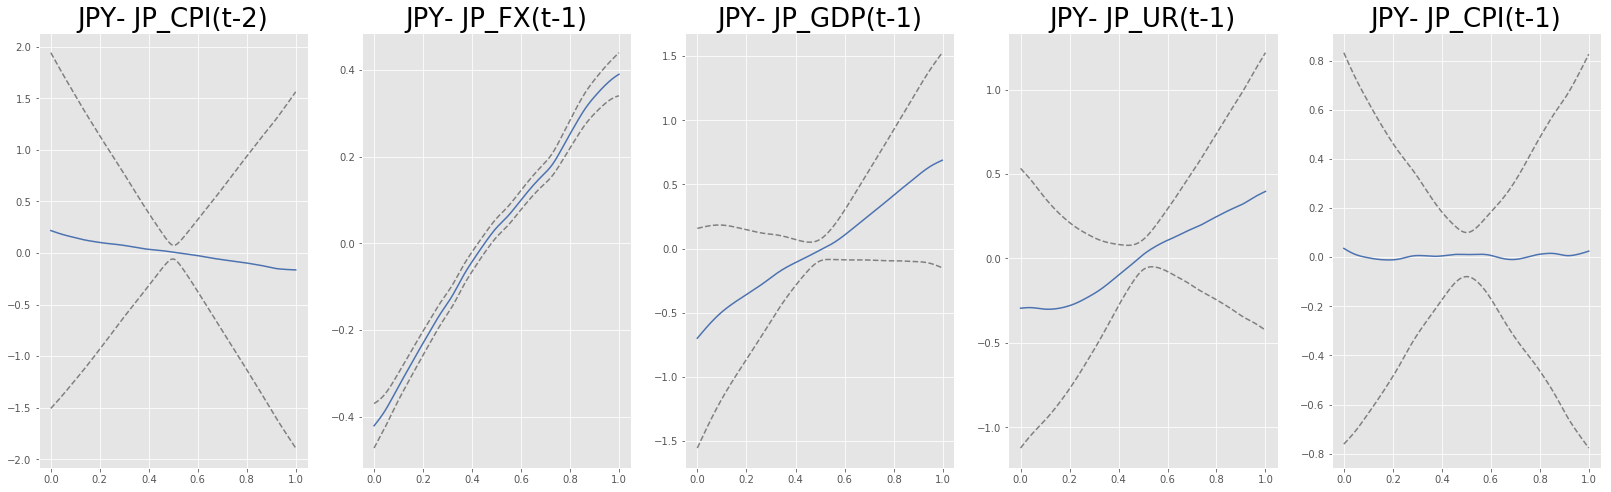

RMSE: 0.00013


RMSE: 0.00012


In [35]:
naive_rmse, fx_features_rmse = do_one_model('JPY', feature_col_names = ['JP_FX', 'JP_GDP', 'JP_UR', 'JP_CPI'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 141)
Reframed data shape: (4708, 988)


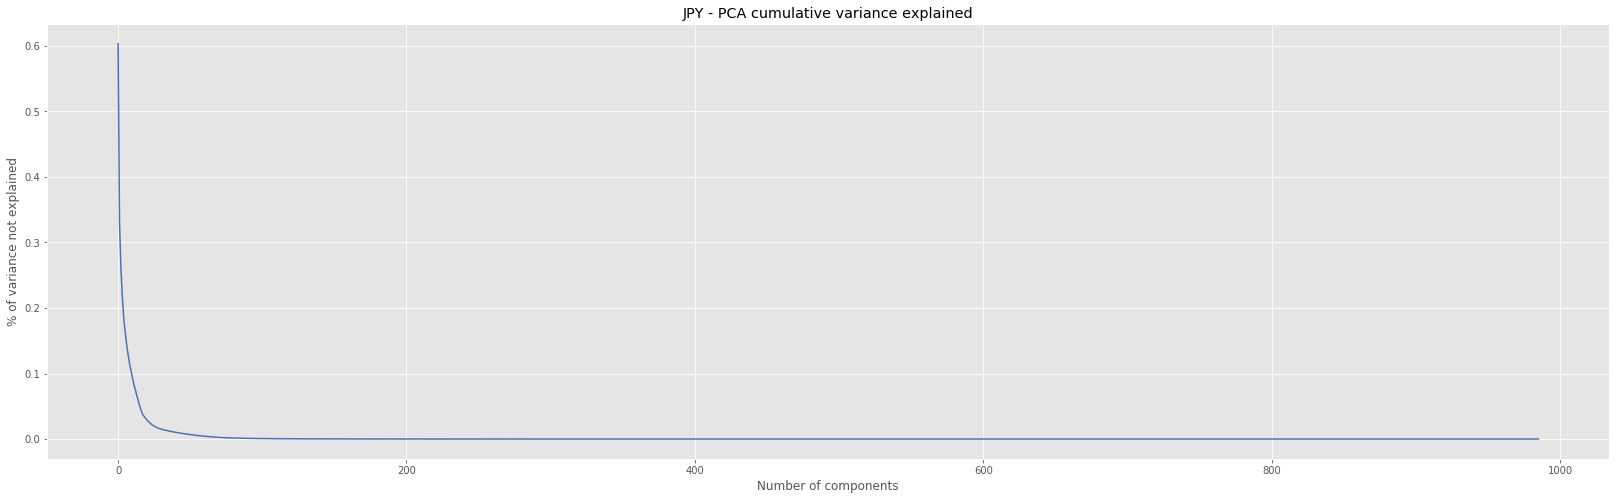

Cumulative variance explained by the first 93 components: 0.999


Reduced data shape: (4708, 94)


(3149, 93) (3149,) (1552, 93) (1552,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/pygam.py:597: RuntimeWarning: divide by zero encountered in log
  return np.log(self.distribution.pdf(y=y, mu=mu, weights=weights)).sum()
  9% (1 of 11) |##                        | Elapsed Time: 0:00:16 ETA:  0:02:49/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Spar

RMSE: 0.00015


RMSE: 0.0001


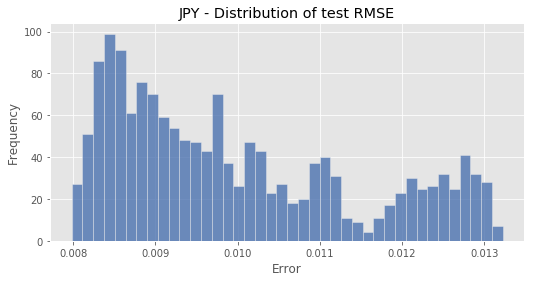

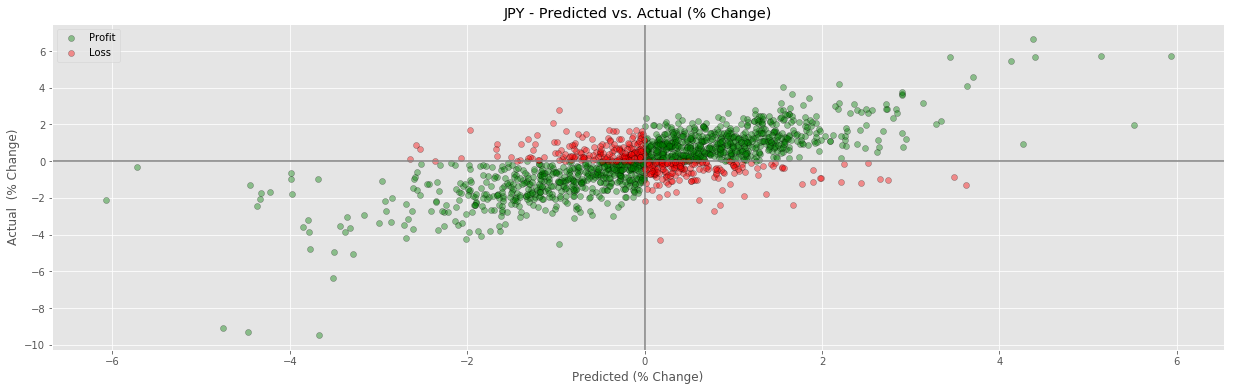

In [36]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('JP_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('JPY', feature_col_names = ['JP_FX'] + cols, do_pca = True)

In [37]:
all_results = accum_results(all_results, 'JPY', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

## Switzerland

### FX rates only

In [38]:
naive_rmse, fx_rmse = do_one_model('CHF', feature_col_names = ['CH_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


CH_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:00 ETA:  0:00:02/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:00 ETA:  0:00:01/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

RMSE: 0.01735


RMSE: 0.01702


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


CH_FX, CH_INT_TB, CH_GDP, CH_CPI, CH_UR

Scaled data shape: (6551, 5)
Reframed data shape: (6538, 36)


CH_FX(t-7),CH_INT_TB(t-7),CH_GDP(t-7),CH_CPI(t-7),CH_UR(t-7),CH_FX(t-6),CH_INT_TB(t-6),CH_GDP(t-6),CH_CPI(t-6),CH_UR(t-6),CH_FX(t-5),CH_INT_TB(t-5),CH_GDP(t-5),CH_CPI(t-5),CH_UR(t-5),CH_FX(t-4),CH_INT_TB(t-4),CH_GDP(t-4),CH_CPI(t-4),CH_UR(t-4),CH_FX(t-3),CH_INT_TB(t-3),CH_GDP(t-3),CH_CPI(t-3),CH_UR(t-3),CH_FX(t-2),CH_INT_TB(t-2),CH_GDP(t-2),CH_CPI(t-2),CH_UR(t-2),CH_FX(t-1),CH_INT_TB(t-1),CH_GDP(t-1),CH_CPI(t-1),CH_UR(t-1),CH_FX(t+6)
0.777068,0.914547,0.811697,0.666667,0.191462,0.754884,0.915161,0.810766,0.666667,0.191040,0.751324,0.915774,0.809834,0.666667,0.190617,0.752602,0.916388,0.808903,0.666667,0.190194,0.760179,0.917002,0.807972,0.666667,0.189772,0.762644,0.917616,0.807040,0.666667,0.189349,0.765109,0.918230,0.806109,0.666667,0.188926,0.789483
0.754884,0.915161,0.810766,0.666667,0.191040,0.751324,0.915774,0.809834,0.666667,0.190617,0.752602,0.916388,0.808903,0.666667,0.190194,0.760179,0.917002,0.807972,0.666667,0.189772,0.762644,0.917616,0.807040,0.666667,0.189349,0.765109,0.918230,0.806109,0.666667,0.188926,0.767573,0.918843,0.805178,0.666667,0.188504,0.789438
0.751324,0.915774,0.809834,0.666667,0.190617,0.752602,0.916388,0.808903,0.666667,0.190194,0.760179,0.917002,0.807972,0.666667,0.189772,0.762644,0.917616,0.807040,0.666667,0.189349,0.765109,0.918230,0.806109,0.666667,0.188926,0.767573,0.918843,0.805178,0.666667,0.188504,0.758536,0.919457,0.804247,0.666667,0.188081,0.789301
0.752602,0.916388,0.808903,0.666667,0.190194,0.760179,0.917002,0.807972,0.666667,0.189772,0.762644,0.917616,0.807040,0.666667,0.189349,0.765109,0.918230,0.806109,0.666667,0.188926,0.767573,0.918843,0.805178,0.666667,0.188504,0.758536,0.919457,0.804247,0.666667,0.188081,0.763557,0.920071,0.803315,0.666667,0.187658,0.791400
0.760179,0.917002,0.807972,0.666667,0.189772,0.762644,0.917616,0.807040,0.666667,0.189349,0.765109,0.918230,0.806109,0.666667,0.188926,0.767573,0.918843,0.805178,0.666667,0.188504,0.758536,0.919457,0.804247,0.666667,0.188081,0.763557,0.920071,0.803315,0.666667,0.187658,0.767847,0.920685,0.802384,0.666667,0.187236,0.786836


(4375, 35) (4375,) (2156, 35) (2156,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/pygam.py:597: RuntimeWarning: divide by zero encountered in log
  return np.log(self.distribution.pdf(y=y, mu=mu, weights=weights)).sum()
  9% (1 of 11) |##                        | Elapsed Time: 0:00:02 ETA:  0:00:21/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Spar

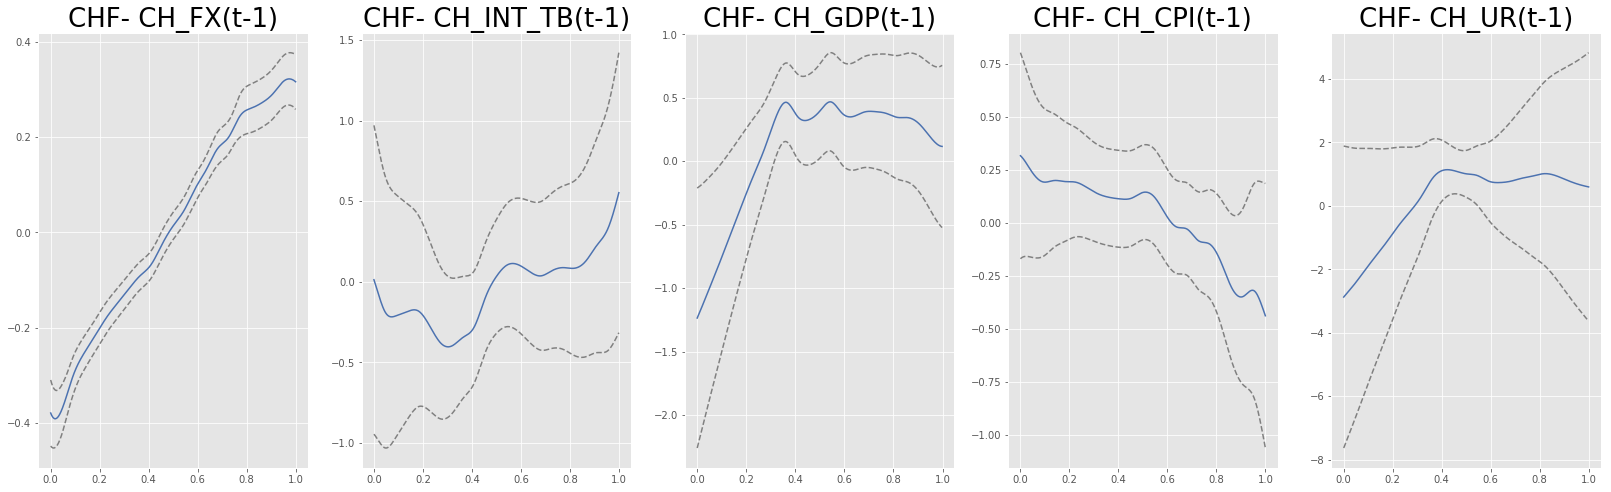

RMSE: 0.01735


RMSE: 0.01488


In [39]:
naive_rmse, fx_features_rmse = do_one_model('CHF', feature_col_names = \
    ['CH_FX', 'CH_INT_TB', 'CH_GDP', 'CH_CPI', 'CH_UR'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 141)
Reframed data shape: (4708, 988)


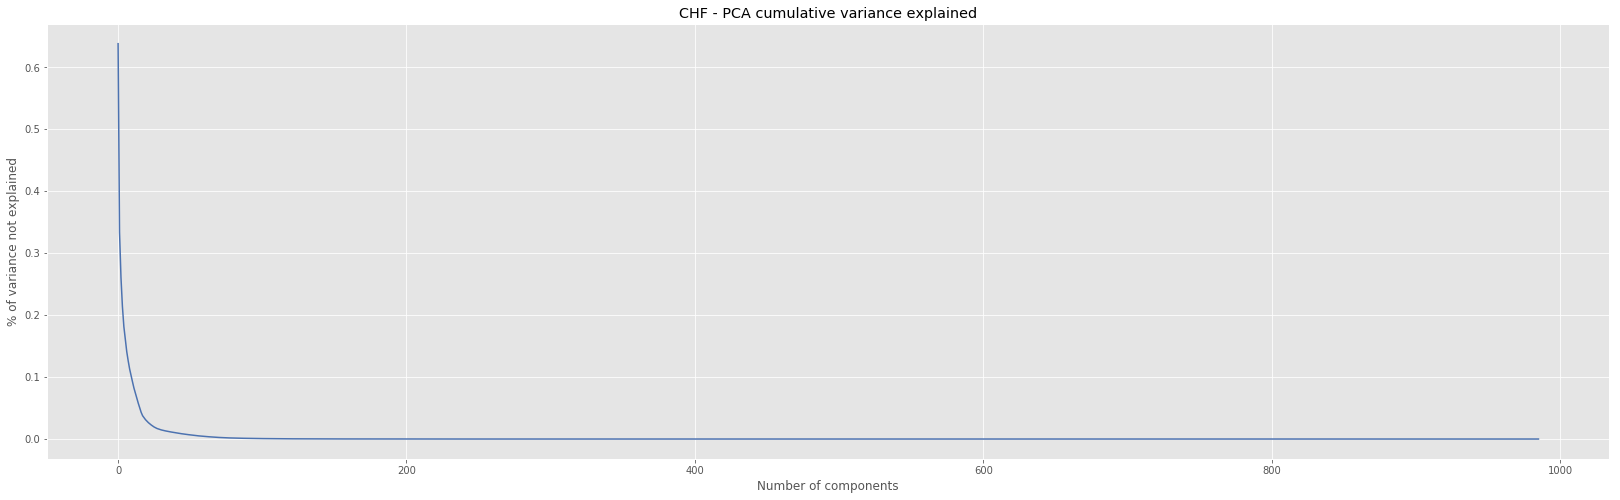

Cumulative variance explained by the first 93 components: 0.999


Reduced data shape: (4708, 94)


(3149, 93) (3149,) (1552, 93) (1552,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/pygam.py:597: RuntimeWarning: divide by zero encountered in log
  return np.log(self.distribution.pdf(y=y, mu=mu, weights=weights)).sum()
  9% (1 of 11) |##                        | Elapsed Time: 0:00:16 ETA:  0:02:48/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Spar

RMSE: 0.01652


RMSE: 0.0098


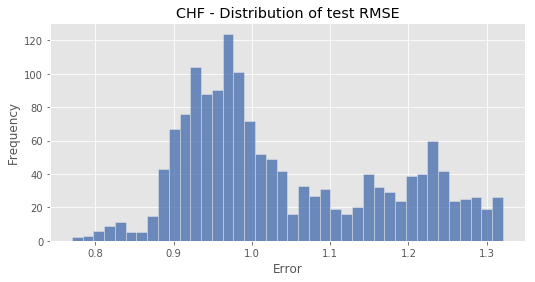

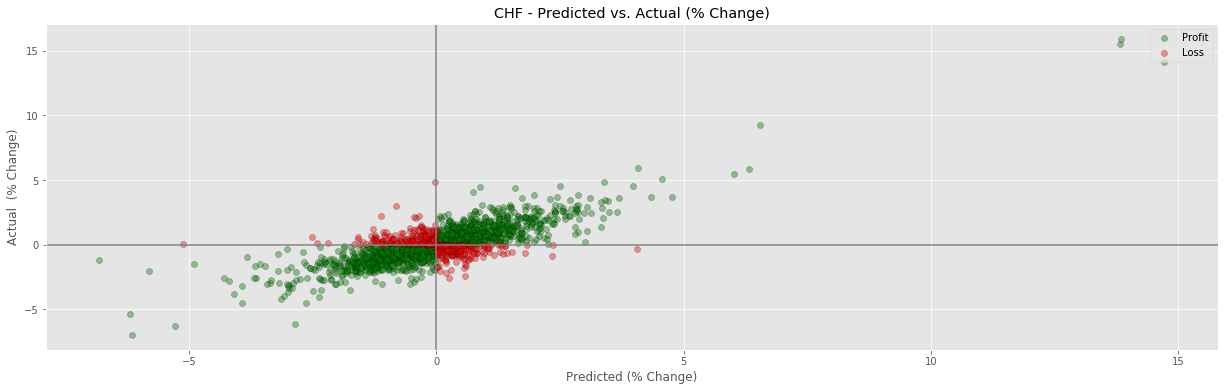

In [40]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('CH_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('CHF', feature_col_names = ['CH_FX'] + cols, do_pca = True)

In [41]:
all_results = accum_results(all_results, 'CHF', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

## UK

### FX rates only

In [42]:
naive_rmse, fx_rmse = do_one_model('GBP', feature_col_names = ['UK_FX'], verbose = 0)

Time period: 2000-01-03 - 2017-12-09


UK_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6538, 8)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:00 ETA:  0:00:02/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:00 ETA:  0:00:01/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

RMSE: 0.02068


RMSE: 0.02058


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


UK_FX, UK_GDP, US_INT_TB

Scaled data shape: (6551, 3)
Reframed data shape: (6538, 22)


UK_FX(t-7),UK_GDP(t-7),US_INT_TB(t-7),UK_FX(t-6),UK_GDP(t-6),US_INT_TB(t-6),UK_FX(t-5),UK_GDP(t-5),US_INT_TB(t-5),UK_FX(t-4),UK_GDP(t-4),US_INT_TB(t-4),UK_FX(t-3),UK_GDP(t-3),US_INT_TB(t-3),UK_FX(t-2),UK_GDP(t-2),US_INT_TB(t-2),UK_FX(t-1),UK_GDP(t-1),US_INT_TB(t-1),UK_FX(t+6)
0.462052,0.850790,0.864422,0.473181,0.850158,0.865626,0.478188,0.849526,0.866831,0.484865,0.848894,0.868035,0.474738,0.848261,0.869240,0.474368,0.847629,0.870444,0.473997,0.846997,0.871649,0.472290
0.473181,0.850158,0.865626,0.478188,0.849526,0.866831,0.484865,0.848894,0.868035,0.474738,0.848261,0.869240,0.474368,0.847629,0.870444,0.473997,0.846997,0.871649,0.473626,0.846365,0.872853,0.472791
0.478188,0.849526,0.866831,0.484865,0.848894,0.868035,0.474738,0.848261,0.869240,0.474368,0.847629,0.870444,0.473997,0.846997,0.871649,0.473626,0.846365,0.872853,0.485422,0.845732,0.874057,0.474293
0.484865,0.848894,0.868035,0.474738,0.848261,0.869240,0.474368,0.847629,0.870444,0.473997,0.846997,0.871649,0.473626,0.846365,0.872853,0.485422,0.845732,0.874057,0.483753,0.845100,0.875262,0.480748
0.474738,0.848261,0.869240,0.474368,0.847629,0.870444,0.473997,0.846997,0.871649,0.473626,0.846365,0.872853,0.485422,0.845732,0.874057,0.483753,0.845100,0.875262,0.485644,0.844468,0.876466,0.491876


(4375, 21) (4375,) (2156, 21) (2156,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
  9% (1 of 11) |##                        | Elapsed Time: 0:00:00 ETA:  0:00:09/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
 18% (2 of 11) |####                      | Elapsed Time: 0:00:01 ETA:  0:00:08/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.p

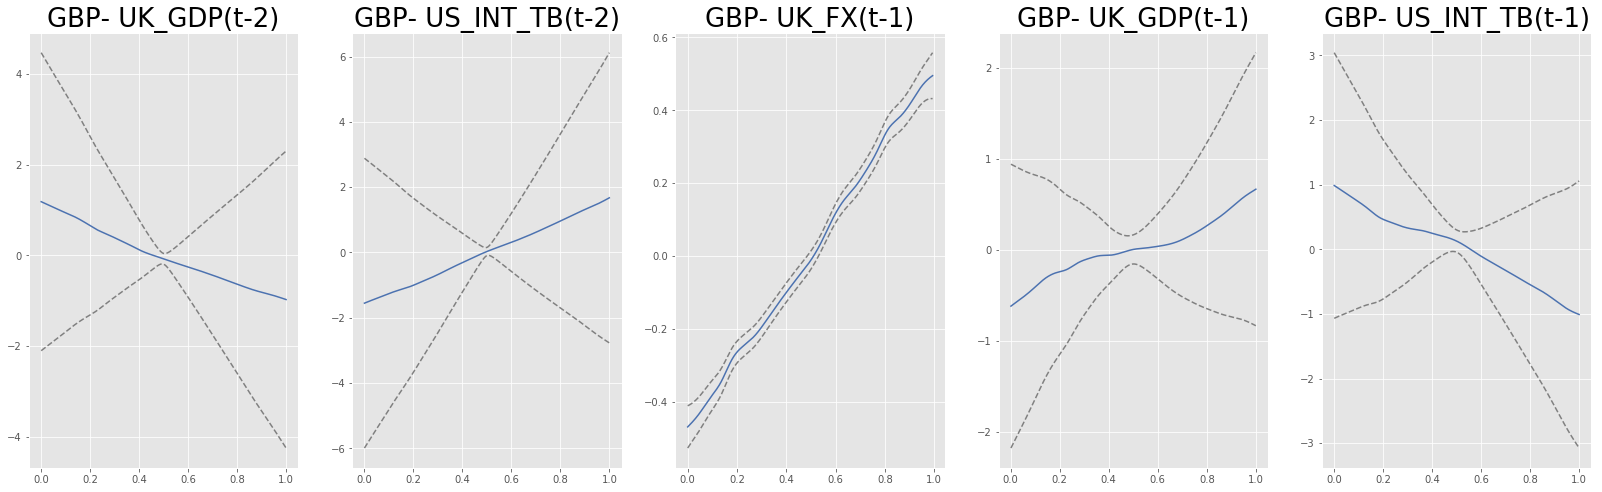

RMSE: 0.02068


RMSE: 0.01891


In [43]:
naive_rmse, fx_features_rmse = do_one_model('GBP', feature_col_names = ['UK_FX', 'UK_GDP', 'US_INT_TB'])

### All features

Time period: 2000-01-03 - 2012-12-05
Scaled data shape: (4721, 141)
Reframed data shape: (4708, 988)


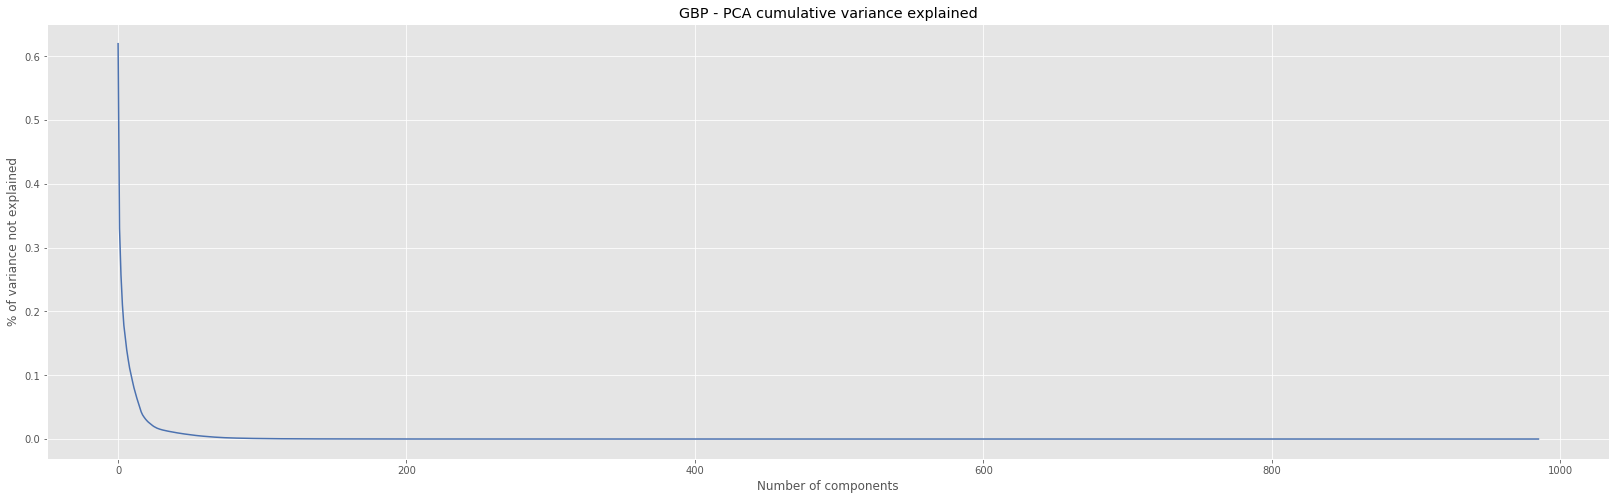

Cumulative variance explained by the first 93 components: 0.999


Reduced data shape: (4708, 94)


(3149, 93) (3149,) (1552, 93) (1552,)


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/pygam.py:597: RuntimeWarning: divide by zero encountered in log
  return np.log(self.distribution.pdf(y=y, mu=mu, weights=weights)).sum()
  9% (1 of 11) |##                        | Elapsed Time: 0:00:16 ETA:  0:02:49/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Spar

RMSE: 0.0229


RMSE: 0.01342


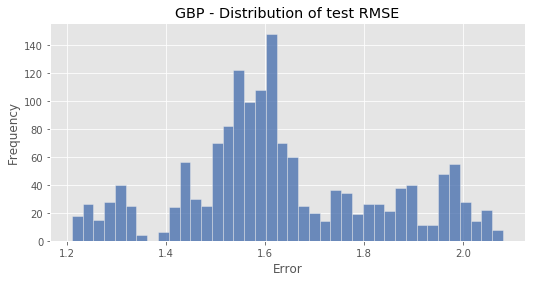

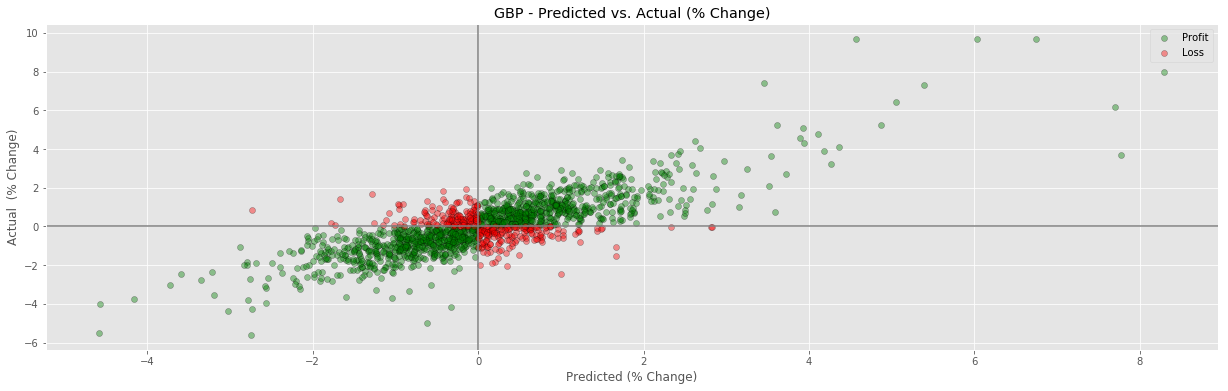

In [44]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('UK_FX', feature_cols[i]) == None]
naive_rmse, fx_all_rmse = do_one_model('GBP', feature_col_names = ['UK_FX'] + cols, do_pca = True)

In [45]:
all_results = accum_results(all_results, 'GBP', naive_rmse, fx_rmse, fx_features_rmse, fx_all_rmse)

# Summary of results

#### Test RMSE for all FX rates (relative to USD)

In [46]:
all_results = all_results[['Currency', 'Naive', 'FX Only', 'FX + Features', 'All Features']]
all_results.to_csv('RMSE_GAM_7.csv', index = False)

pd.options.display.float_format = '{:,.5f}'.format
my_linespace()
my_display_df(all_results)

Currency,Naive,FX Only,FX + Features,All Features
AUD,0.01553,0.01373,0.01220,0.00920
CAD,0.01205,0.01060,0.00935,0.00721
EUR,0.01811,0.01680,0.01595,0.01160
JPY,0.00015,0.00013,0.00012,0.00010
CHF,0.01652,0.01702,0.01488,0.00980
GBP,0.02290,0.02058,0.01891,0.01342


#### Test RMSE as a share of naive RMSE for all FX rates (relative to USD)

In [47]:
pd.options.display.float_format = '{:,.2f}'.format

all_results_2 = all_results.drop('Naive', axis = 1)
all_results_2['FX Only'] = np.round(all_results['FX Only'] / all_results['Naive'], 3)
all_results_2['FX + Features'] = np.round(all_results['FX + Features'] / all_results['Naive'], 3)
all_results_2['All Features'] = np.round(all_results['All Features'] / all_results['Naive'], 3)
all_results_2 = all_results_2[['Currency', 'FX Only', 'FX + Features', 'All Features']]
all_results_2.to_csv('Test_Naive_GAM_7.csv', index = False)

my_linespace()
my_display_df(all_results_2)

Currency,FX Only,FX + Features,All Features
AUD,0.89,0.79,0.59
CAD,0.88,0.78,0.60
EUR,0.93,0.88,0.64
JPY,0.90,0.84,0.70
CHF,1.03,0.90,0.59
GBP,0.90,0.83,0.59


#### Visualize test RMSE as a share of naive RMSE

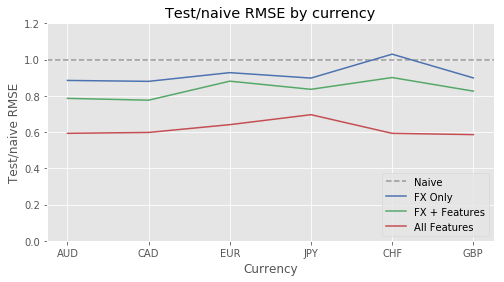

In [48]:
n_items = all_results.shape[0]

print()
fig, ax = plt.subplots(figsize = (8, 4))

ax.axhline(y = 1.0, color = '0.6', linestyle = '--', label = 'Naive')

ax.plot(range(n_items), all_results_2['FX Only'], label = 'FX Only')
ax.plot(range(n_items), all_results_2['FX + Features'], label = 'FX + Features')
ax.plot(range(n_items), all_results_2['All Features'], label = 'All Features')

ax.set_ylim((0., 1.2))
ax.set_xticks(range(n_items))
ax.set_xticklabels(all_results_2['Currency'])

ax.set_xlabel('Currency')
ax.set_ylabel('Test/naive RMSE')
ax.set_title('Test/naive RMSE by currency')

plt.legend(loc = 'lower right')
plt.show()